In [1]:
# @title Install dependencies and basic parameters
!pip install nilearn -qqq --progress-bar off

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import tarfile
import nilearn
import nilearn.decoding

# Necessary for visualization
from nilearn import plotting, datasets

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./DATA"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339
# N_SUBJECTS = 1200

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

In [4]:
fnames = ["hcp_rest.tgz",
          "hcp_task.tgz",
          "hcp_covariates.tgz",
          "atlas.npz"]
urls = ["https://osf.io/bqp7m/download",
        "https://osf.io/s4h8j/download",
        "https://osf.io/x5p4g/download",
        "https://osf.io/j5kuc/download"]

for fname, url in zip(fnames, urls):
    if not os.path.isfile(fname):
        try:
            r = requests.get(url)
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
        else:
            if r.status_code != requests.codes.ok:
                print("!!! Failed to download data !!!")
            else:
                print(f"Downloading {fname}...")
                with open(fname, "wb") as fid:
                    fid.write(r.content)
                print(f"Download {fname} completed!")


fnames = ["hcp_covariates", "hcp_rest", "hcp_task"]

for fname in fnames:
    # open file
    path_name = os.path.join(HCP_DIR, fname)
    if not os.path.exists(path_name):
        print(f"Extracting {fname}.tgz...")
        with tarfile.open(f"{fname}.tgz") as fzip:
            fzip.extractall(HCP_DIR)
    else:
        print(f"File {fname}.tgz has already been extracted.")

Download hcp_rest.tgz completed!
Download hcp_task.tgz completed!
Download hcp_covariates.tgz completed!
Download atlas.npz completed!
Extracting hcp_covariates.tgz...
Extracting hcp_rest.tgz...
Extracting hcp_task.tgz...


In [17]:
# !rm -r ./DATA

## Loading region information

Downloading either dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

In [5]:
dir = os.path.join(HCP_DIR, "hcp_task")  # choose the data directory
regions = np.load(os.path.join(dir, "regions.npy")).T
region_info = dict(name=regions[0].tolist(),
                   network=regions[1],
                   myelin=regions[2].astype(float)
                   )

In [6]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
             i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
             ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}'")
  return run_ids


def load_timeseries(subject, name, dir,
                    runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    dir (str) : data directory
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]
  # Get the first (1-based) run id for this experiment
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
               load_single_timeseries(subject,
                                      offset + run,
                                      dir,
                                      remove_mean) for run in runs
               ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, dir, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    dir (str) : data directory
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(os.path.join(bold_path, bold_file))
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, name, condition, dir):
    """Load EV (explanatory variable) data for one task condition.

    Args:
        subject (int): 0-based subject ID to load
        name (str) : Name of task
        condition (str) : Name of condition
        dir (str) : data directory

    Returns
        evs (list of dicts): A dictionary with the onset, duration, and amplitude
            of the condition for each run.

    """
    evs = []
    for id in get_image_ids(name):
        task_key = BOLD_NAMES[id - 1]
        ev_file = os.path.join(dir, "subjects", str(subject), "EVs",
                               task_key, f"{condition}.txt")
        ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
        ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
        evs.append(ev)
    return evs

In [7]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0, actually_average=True):
    """Take the temporal mean across frames for a given condition.

    Args:
        timeseries_data (array or list of arrays): n_parcel x n_tp arrays
        ev (dict or list of dicts): Condition timing information
        skip (int) : Ignore this many frames at the start of each trial, to account
        for hemodynamic lag

    Returns:
        avg_data (1D array): Data averagted across selected image frames based
        on condition timing

    """
    # Ensure that we have lists of the same length
    if not isinstance(timeseries_data, list):
        timeseries_data = [timeseries_data]
    if not isinstance(ev, list):
        ev = [ev]
    if len(timeseries_data) != len(ev):
        raise ValueError("Length of `timeseries_data` and `ev` must match.")

    # Identify the indices of relevant frames
    frames = condition_frames(ev, skip)

    # Select the frames from each image
    selected_data = []
    for run_data, run_frames in zip(timeseries_data, frames):
        run_frames = run_frames[run_frames < run_data.shape[1]]
        selected_data.append(run_data[:, run_frames])

    # Take the average in each parcel
    if actually_average:
        avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)
    else:
        avg_data = np.concatenate(selected_data, axis=-1)

    return avg_data

## GAMBLING

In [8]:
timeseries_gambling = []
for subject in subjects:
    timeseries_gambling.append(load_timeseries(subject, "GAMBLING",
                                               dir=os.path.join(HCP_DIR, "hcp_task"),
                                               concat=False))

In [43]:
task = "GAMBLING"
conditions = ["win", "loss"]

win_loss = []
for subject in subjects:

    # Get the average signal in each region for each condition
    evs = [load_evs(subject, task, cond, dir=os.path.join(HCP_DIR, "hcp_task")) for cond in conditions]
    avgs = [selective_average(timeseries_gambling[subject], ev) for ev in evs]

    win_loss.append(avgs)

win_loss_ml = np.array(win_loss)
win_loss_ml.shape

(339, 2, 360)

Осталось только выяснить, кто из conditions win, а кто loss

In [44]:
win_data = win_loss_ml[:,0,:]
loss_data = win_loss_ml[:,1,:]
win_data.shape, loss_data.shape

((339, 360), (339, 360))

### Classical approach

In [45]:
win_data_a1e2 = np.concatenate((win_data, np.array([[1]*win_data.shape[0]]).T), axis=1)
loss_data_a1e2 = np.concatenate((loss_data, np.array([[0]*loss_data.shape[0]]).T), axis=1)

win_loss_data = np.concatenate((win_data_a1e2, loss_data_a1e2), axis=0)

In [46]:
X_gambling = win_loss_data[:,:360]
y_gambling = win_loss_data[:,360]

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_gambling, y_gambling, test_size=0.2, shuffle=True, random_state=88)

X_gambling = np.concatenate((X_train_g, X_test_g), axis=0)
y_gambling = np.concatenate((y_train_g, y_test_g), axis=0)

In [47]:
# Go ML -> -> ->

inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)

def nested_cv(estimator, param_grid, X, y):

    model = GridSearchCV(
        estimator, param_grid, cv=inner_cv, n_jobs=2
    )

    # Outer cross-validation to compute the testing score
    test_score = cross_val_score(model, X, y, cv=outer_cv, n_jobs=2, scoring='accuracy')
    print(
        "The mean score using nested cross-validation is: "
        f"{test_score.mean():.3f} ± {test_score.std():.3f}"
    )

    return model

In [48]:
param_grid_rfc = {
    'n_estimators': [100, 150, 200],
    'max_depth': [2, 3, 4]
}

gs = nested_cv(RandomForestClassifier(random_state=88), param_grid_rfc, X_gambling, y_gambling)

The mean score using nested cross-validation is: 0.814 ± 0.031


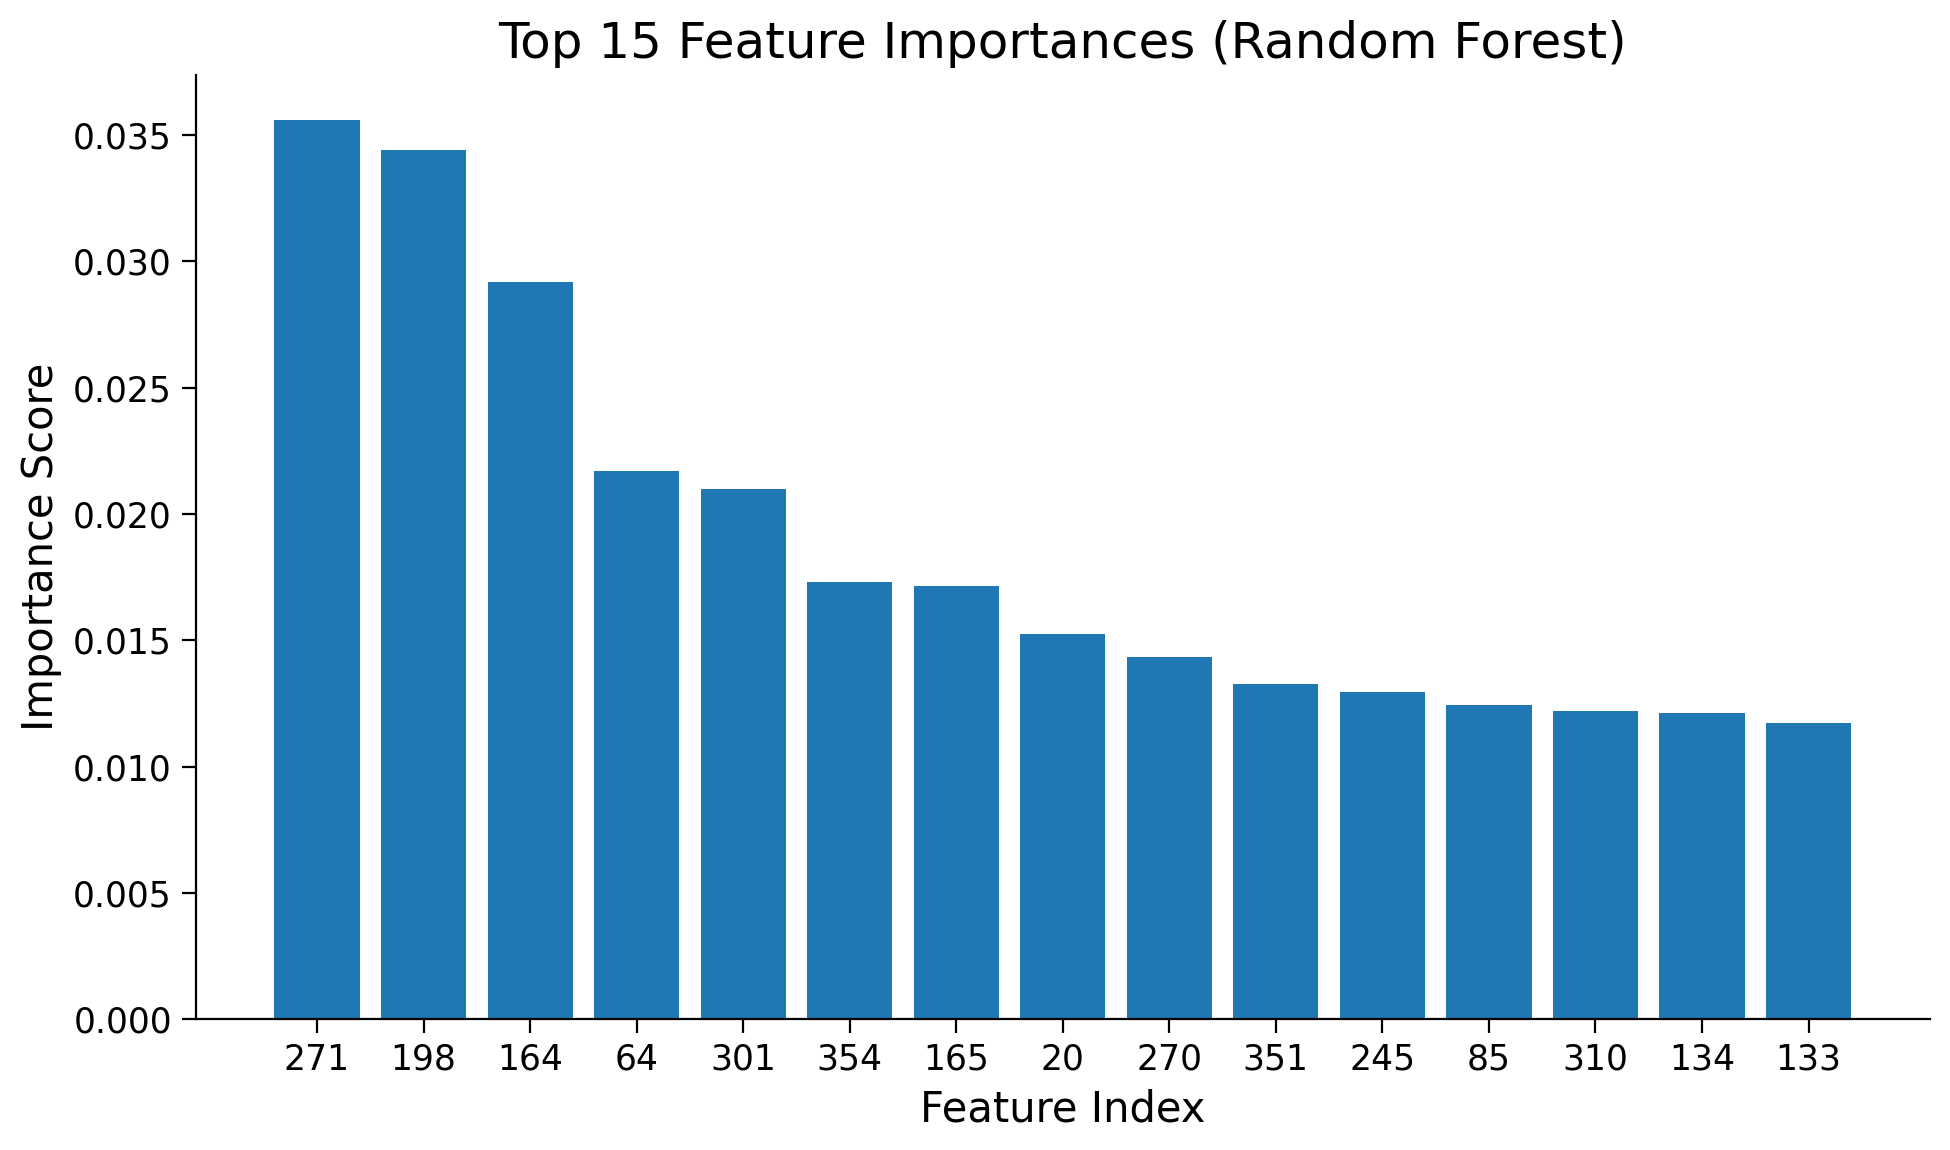

In [49]:
gs_fitted = gs.fit(X_gambling, y_gambling)
rfc_gs = RandomForestClassifier(**(gs_fitted.best_params_))

rfc_gs.fit(X_gambling, y_gambling)
importances = rfc_gs.feature_importances_

indices = np.argsort(importances)[::-1]
top_indices = indices[:15]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances (Random Forest)")
plt.bar(range(15), importances[top_indices], align="center")
plt.xticks(range(15), top_indices)
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

In [57]:
param_grid_abc = {
    'n_estimators': [10, 25, 50],
}

gs = nested_cv(AdaBoostClassifier(random_state=88), param_grid_abc, X_gambling, y_gambling)

The mean score using nested cross-validation is: 0.860 ± 0.010


In [50]:
param_grid_lr = {
    'C': [0.05, 0.1, 0.5, 1],
    'penalty': ['l1','l2'],
}

ss = StandardScaler().fit(X_gambling)

X_gambling_t = ss.transform(X_gambling)

gs = nested_cv(LogisticRegression(random_state=88), param_grid_lr, X_gambling_t, y_gambling)

The mean score using nested cross-validation is: 0.904 ± 0.021


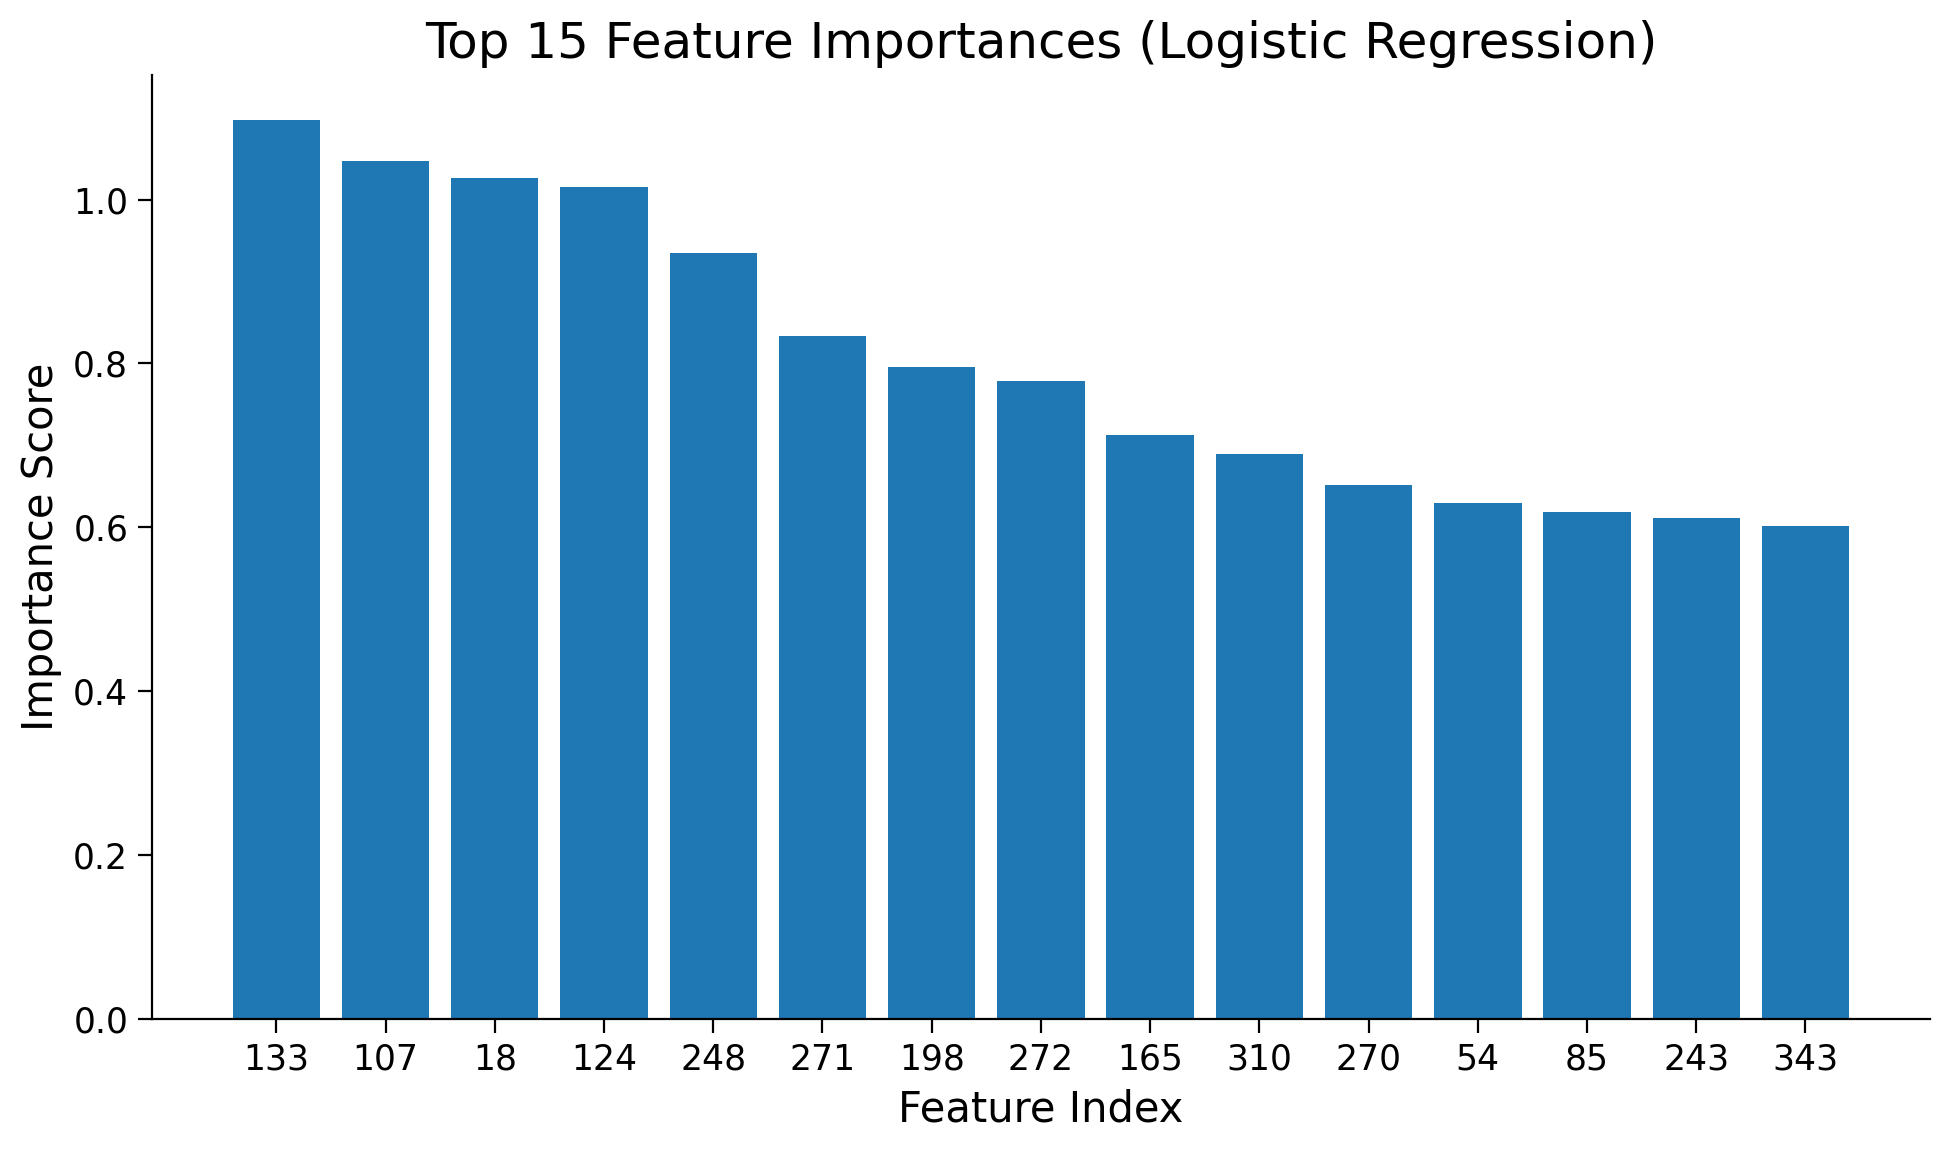

In [51]:
gs_fitted = gs.fit(X_gambling_t, y_gambling)
lr_gs = LogisticRegression(**(gs_fitted.best_params_))

lr_gs.fit(X_gambling_t, y_gambling)

coefficients = lr_gs.coef_[0]
importances = np.abs(coefficients)

indices = np.argsort(importances)[::-1]
top_indices = indices[:15]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances (Logistic Regression)")
plt.bar(range(15), importances[top_indices], align="center")
plt.xticks(range(15), top_indices)
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

### Timeseries and PCA (and DL start)

In [46]:
task = "GAMBLING"
conditions = ["win", "loss"]

win_loss = []
for subject in subjects:

    # Get the average signal in each region for each condition
    evs = [load_evs(subject, task, cond, dir=os.path.join(HCP_DIR, "hcp_task")) for cond in conditions]
    avgs = [selective_average(timeseries_gambling[subject], ev, actually_average=False) for ev in evs]

    win_loss.append(avgs)

win_loss_pca = np.array(win_loss)

win_pca_a1 = win_loss_pca[:,0,:,:]
loss_pca_a1 = win_loss_pca[:,1,:,:]

win_loss_pca.shape

(339, 2, 360, 156)

In [48]:
win_data_a2e1 = win_pca_a1.reshape(339, -1)
loss_data_a2e1 = loss_pca_a1.reshape(339, -1)

win_loss_data_a2 = np.concatenate((win_data_a2e1, loss_data_a2e1), axis=0)
win_loss_data_a2.shape

(678, 56160)

In [59]:
X_ts = win_loss_data_a2
y_ts = np.array([1]*(win_loss_data_a2.shape[0]//2) + [0]*(win_loss_data_a2.shape[0]//2))

In [60]:
# Go dim reduce -> -> ->

pca = PCA(n_components=300).fit(X_ts)
X_ts_t = pca.transform(X_ts)

In [61]:
param_grid_rfc = {
    'n_estimators': [10, 25, 50],
    'max_depth': [2, 3, 4]
}

gs = nested_cv(RandomForestClassifier(random_state=88), param_grid_rfc, X_ts_t, y_ts)

The mean score using nested cross-validation is: 0.850 ± 0.034


In [62]:
param_grid_abc = {
    'n_estimators': [10, 25, 50],
}

gs = nested_cv(AdaBoostClassifier(random_state=88), param_grid_abc, X_ts_t, y_ts)

The mean score using nested cross-validation is: 0.891 ± 0.006


In [63]:
param_grid_lr = {
    'C': [0.05, 0.1, 0.5, 1],
    'penalty': ['l1','l2'],
}

ss = StandardScaler().fit(X_ts_t)

X_ts_t_s = ss.transform(X_ts_t)

gs = nested_cv(LogisticRegression(random_state=88), param_grid_lr, X_ts_t_s, y_ts)

The mean score using nested cross-validation is: 0.941 ± 0.006


### DL

In [64]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from tqdm import tqdm

In [65]:
# Go convolute -> -> ->

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=(3,3)),
            nn.ReLU(),
            nn.Conv2d(4, 4, kernel_size=(3,3)),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(61504, 2)
        )

    def forward(self, x):
        x = self.net(x.float())
        return x

In [66]:
class MyDataset(Dataset):

    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                         torchvision.transforms.Resize((128,128))])


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.transform(self.images[idx])
        return image.to(float), label

In [69]:
win_pca_a1.shape

(339, 360, 156)

In [70]:
win_loss_data_a3 = np.concatenate((win_pca_a1, loss_pca_a1), axis=0)
labels_a3 = np.array([1]*(win_loss_data_a3.shape[0]//2) + [0]*(win_loss_data_a3.shape[0]//2))

In [72]:
train_images, test_images, train_labels, test_labels = train_test_split(
                                                                        win_loss_data_a3,
                                                                        labels_a3,
                                                                        test_size=0.2,
                                                                        random_state=88,
                                                                        shuffle=True
                                                                       )

In [73]:
batch_size = 8

train_dataset = MyDataset(images=train_images, labels=train_labels)
test_dataset = MyDataset(images=test_images, labels=test_labels)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

dataloaders = {
    'train': train_dataloader,
    'test': test_dataloader
}

In [77]:
def train_model(model, criterion, optimizer, batch_size, dataloaders, num_epochs=10):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for i, (inputs, labels) in enumerate(tqdm(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / (len(dataloaders[phase])*batch_size)
            epoch_acc = (running_corrects) / (len(dataloaders[phase])*batch_size)

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))

    return model

In [78]:
device = torch.device('cpu')
criterion = torch.nn.CrossEntropyLoss()
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model_trained = train_model(model, criterion, optimizer, batch_size, dataloaders, num_epochs=3)

Epoch 1/3
----------


100%|██████████| 68/68 [00:01<00:00, 44.25it/s]


train loss: 1.0177, acc: 0.7831


100%|██████████| 17/17 [00:00<00:00, 125.20it/s]


test loss: 0.3259, acc: 0.9191
Epoch 2/3
----------


100%|██████████| 68/68 [00:02<00:00, 30.48it/s]


train loss: 0.1079, acc: 0.9688


100%|██████████| 17/17 [00:00<00:00, 69.46it/s]


test loss: 0.4536, acc: 0.9265
Epoch 3/3
----------


100%|██████████| 68/68 [00:02<00:00, 33.92it/s]


train loss: 0.0114, acc: 0.9963


100%|██████████| 17/17 [00:00<00:00, 122.17it/s]

test loss: 0.3979, acc: 0.9485


### Augmentation

In [79]:
win_loss_data_a4 = np.concatenate((win_pca_a1, loss_pca_a1), axis=0)
labels_a4 = np.array([1]*(win_loss_data_a4.shape[0]//2) + [0]*(win_loss_data_a4.shape[0]//2))

In [80]:
win_loss_data_a4.shape

(678, 360, 156)

In [86]:
def create_aug(img):

    aug_images = []
    aug_labels = []

    start_shape = 120

    while True:
        try:
            sample = img[:,start_shape-120:start_shape]
            target = img[:,start_shape]

            aug_images.append(sample)
            aug_labels.append(target)

            start_shape += 4

        except:
            return aug_images, aug_labels

In [87]:
aug_images = []
aug_labels = []
true_labels = []

for i in tqdm(range(win_loss_data_a4.shape[0])):

    tl = 1 if i < win_loss_data_a4.shape[0]//2 else 0
    ai, al = create_aug(win_loss_data_a4[i])

    for _ai in ai:
        aug_images.append(_ai)
    for _al in al:
        aug_labels.append(_al)

    true_labels.append(tl)

aug_images = np.array(aug_images)
aug_labels = np.array(aug_labels)
true_labels = np.array(true_labels)

100%|██████████| 678/678 [00:00<00:00, 15921.94it/s]


In [94]:
class AugmentNet(nn.Module):
    def __init__(self):
        super(AugmentNet, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=(3,3)),
            nn.ReLU(),
            nn.Conv2d(4, 4, kernel_size=(3,3)),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(53824, 360)
        )

    def forward(self, x):
        x = self.net(x.float())
        return x

In [88]:
train_images_aug, test_images_aug, train_labels_aug, test_labels_aug = train_test_split(aug_images,
                                                                                        aug_labels,
                                                                                        test_size=0.2,
                                                                                        random_state=88,
                                                                                        shuffle=True
                                                                                        )

In [89]:
class MyAugmentationDataset(Dataset):

    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                         torchvision.transforms.Resize((120,120))])


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.transform(self.images[idx])
        return image.to(float), label

In [90]:
batch_size = 16

train_dataset_aug = MyAugmentationDataset(images=train_images_aug, labels=train_labels_aug)
test_dataset_aug = MyAugmentationDataset(images=test_images_aug, labels=test_labels_aug)

train_dataloader_aug = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True)
test_dataloader_aug = DataLoader(test_dataset_aug, batch_size=batch_size, shuffle=True)

dataloaders_aug = {
    'train': train_dataloader_aug,
    'test': test_dataloader_aug
}

In [91]:
def train_model_aug(model, criterion, optimizer, batch_size, dataloaders, num_epochs=10):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for i, (inputs, labels) in enumerate(tqdm(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = torch.sqrt(criterion(outputs.float(), labels.float()))

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                # _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                # print(preds.shape, labels.shape)
                running_corrects += torch.sum(outputs == labels.data)

            epoch_loss = running_loss / (len(dataloaders[phase])*batch_size)
            # epoch_acc = (running_corrects) / (len(dataloaders[phase])*batch_size)

            print('{} loss: {:.4f}'.format(phase, epoch_loss))

    return model

In [92]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [95]:
criterion = nn.MSELoss()
model = AugmentNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model_trained = train_model_aug(model, criterion, optimizer, batch_size, dataloaders_aug, num_epochs=10)

Epoch 1/10
----------


100%|██████████| 306/306 [00:05<00:00, 60.03it/s]


train loss: 66.9973


100%|██████████| 77/77 [00:00<00:00, 176.66it/s]


test loss: 63.4151
Epoch 2/10
----------


100%|██████████| 306/306 [00:04<00:00, 72.74it/s]


train loss: 55.2912


100%|██████████| 77/77 [00:00<00:00, 176.49it/s]


test loss: 64.1351
Epoch 3/10
----------


100%|██████████| 306/306 [00:04<00:00, 65.35it/s]


train loss: 39.3237


100%|██████████| 77/77 [00:00<00:00, 180.81it/s]


test loss: 65.0379
Epoch 4/10
----------


100%|██████████| 306/306 [00:04<00:00, 72.66it/s]


train loss: 30.0122


100%|██████████| 77/77 [00:00<00:00, 187.73it/s]


test loss: 65.9388
Epoch 5/10
----------


100%|██████████| 306/306 [00:04<00:00, 70.72it/s]


train loss: 24.2730


100%|██████████| 77/77 [00:00<00:00, 138.31it/s]


test loss: 65.4422
Epoch 6/10
----------


100%|██████████| 306/306 [00:04<00:00, 66.59it/s]


train loss: 20.1214


100%|██████████| 77/77 [00:00<00:00, 177.37it/s]


test loss: 65.1777
Epoch 7/10
----------


100%|██████████| 306/306 [00:04<00:00, 71.81it/s]


train loss: 17.4785


100%|██████████| 77/77 [00:00<00:00, 179.10it/s]


test loss: 65.5517
Epoch 8/10
----------


100%|██████████| 306/306 [00:04<00:00, 67.63it/s]


train loss: 15.8644


100%|██████████| 77/77 [00:00<00:00, 129.99it/s]


test loss: 65.2300
Epoch 9/10
----------


100%|██████████| 306/306 [00:04<00:00, 71.09it/s]


train loss: 14.7211


100%|██████████| 77/77 [00:00<00:00, 172.92it/s]


test loss: 65.6228
Epoch 10/10
----------


100%|██████████| 306/306 [00:04<00:00, 72.39it/s]


train loss: 13.4347


100%|██████████| 77/77 [00:00<00:00, 185.18it/s]

test loss: 65.7094


In [27]:
import gc
gc.collect()

189

In [28]:
torch.cuda.empty_cache()

## LANGUAGE

In [9]:
timeseries_language = []
for subject in subjects:
    timeseries_language.append(load_timeseries(subject, "LANGUAGE",
                                               dir=os.path.join(HCP_DIR, "hcp_task"),
                                               concat=False))

In [10]:
task = "LANGUAGE"
conditions = ["math", "story"]

math_story = []
for subject in subjects:

    # Get the average signal in each region for each condition
    evs = [load_evs(subject, task, cond, dir=os.path.join(HCP_DIR, "hcp_task")) for cond in conditions]
    avgs = [selective_average(timeseries_language[subject], ev) for ev in evs]

    math_story.append(avgs)

math_story_ml = np.array(math_story)
math_story_ml.shape

(339, 2, 360)

Осталось только выяснить, кто из conditions math, а кто story

In [11]:
math_data = math_story_ml[:,0,:]
story_data = math_story_ml[:,1,:]
math_data.shape, story_data.shape

((339, 360), (339, 360))

### Classical approach

In [12]:
math_data_a1e2 = np.concatenate((math_data, np.array([[1]*math_data.shape[0]]).T), axis=1)
story_data_a1e2 = np.concatenate((story_data, np.array([[0]*story_data.shape[0]]).T), axis=1)

math_story_data = np.concatenate((math_data_a1e2, story_data_a1e2), axis=0)

In [13]:
X_language = math_story_data[:,:360]
y_language = math_story_data[:,360]

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_language, y_language, test_size=0.2, shuffle=True, random_state=88)

X_language = np.concatenate((X_train_l, X_test_l), axis=0)
y_language = np.concatenate((y_train_l, y_test_l), axis=0)

In [14]:
# Go ML -> -> ->

inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)

def nested_cv(estimator, param_grid, X, y):

    model = GridSearchCV(
        estimator, param_grid, cv=inner_cv, n_jobs=2
    )

    # Outer cross-validation to compute the testing score
    test_score = cross_val_score(model, X, y, cv=outer_cv, n_jobs=2, scoring='accuracy')
    print(
        "The mean score using nested cross-validation is: "
        f"{test_score.mean():.3f} ± {test_score.std():.3f}"
    )

    return model

In [15]:
param_grid_rfc = {
    'n_estimators': [10, 20, 30],
    'max_depth': [2, 3, 4]
}
rfc = RandomForestClassifier(random_state=88)
gs = nested_cv(rfc, param_grid_rfc, X_language, y_language)

The mean score using nested cross-validation is: 0.999 ± 0.002


In [ ]:
import warnings
warnings.filterwarnings('ignore')

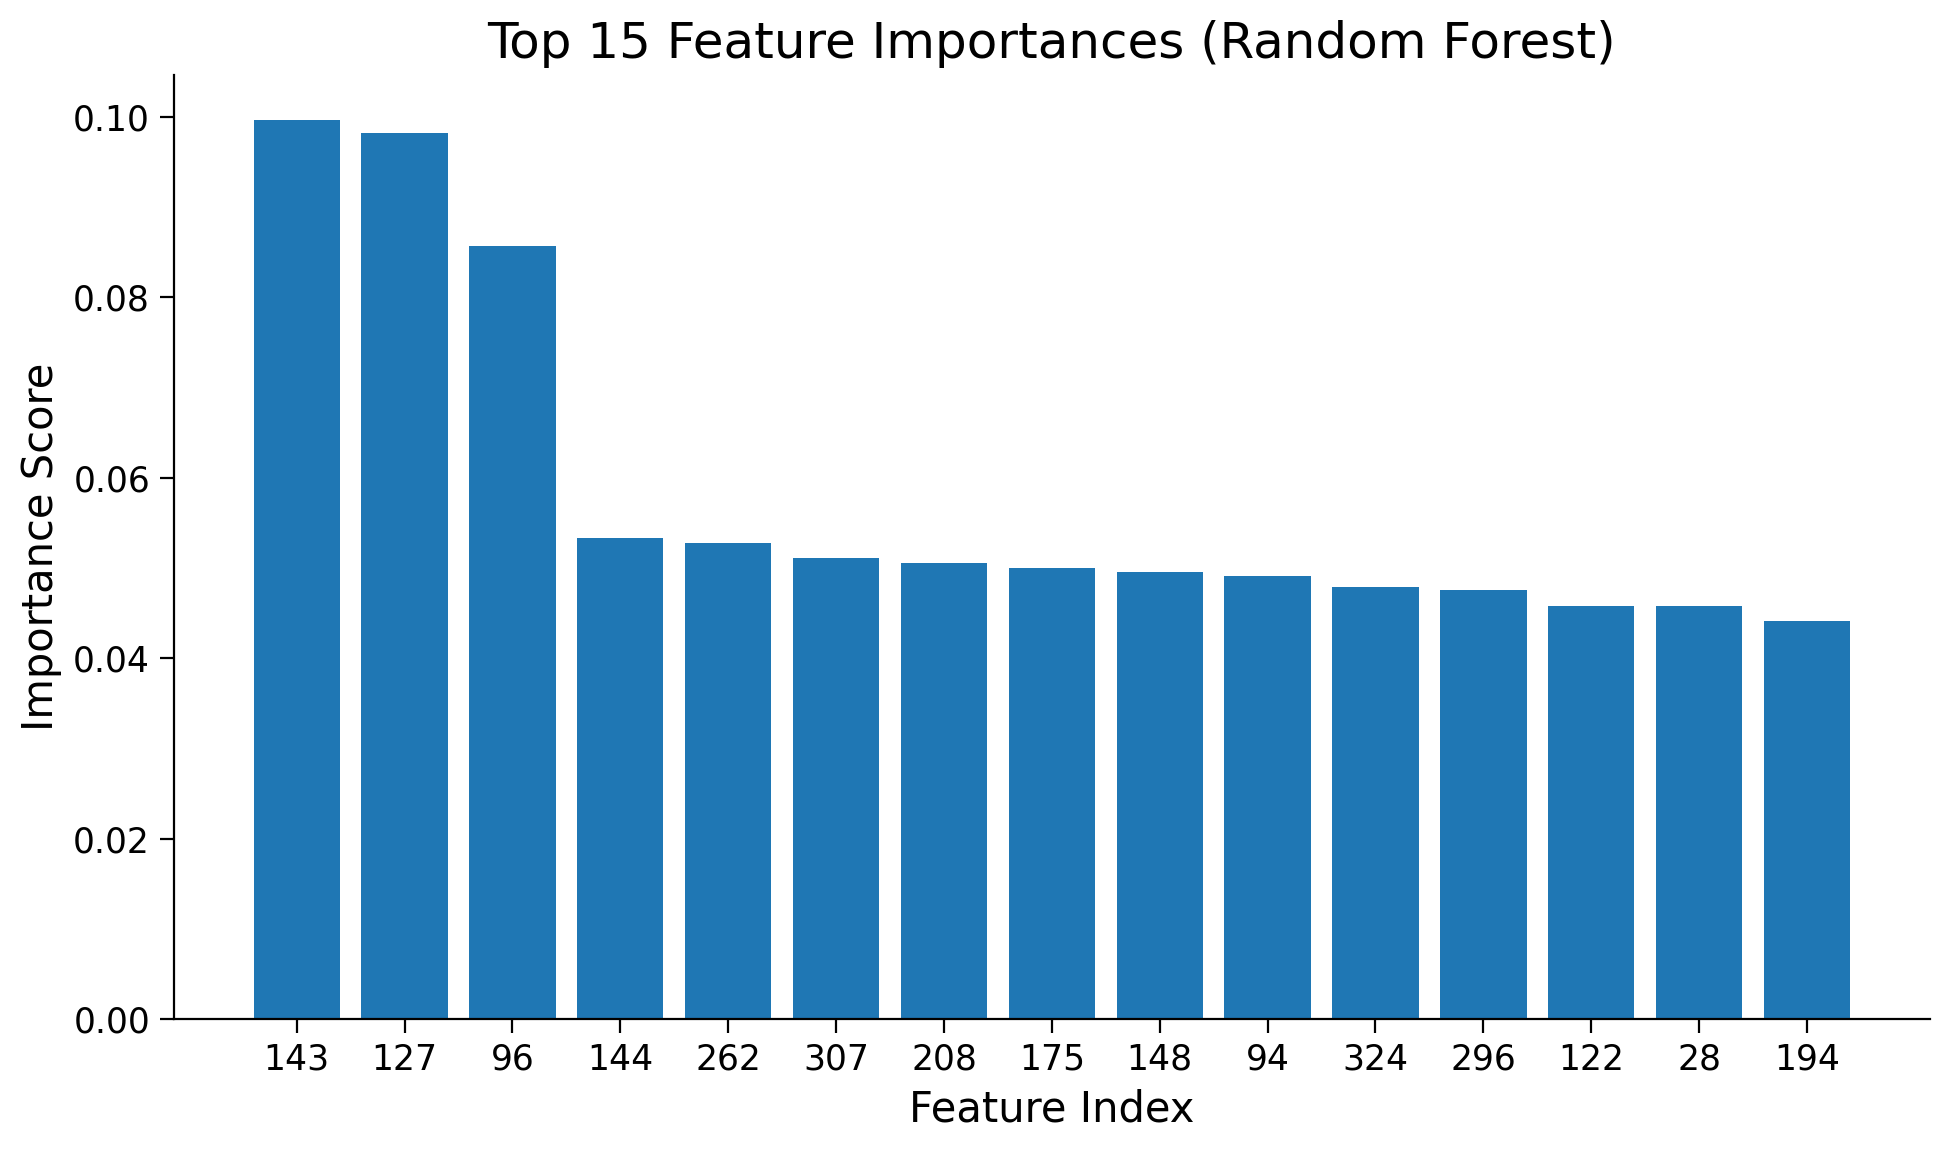

In [28]:
gs_fitted = gs.fit(X_language, y_language)
rfc_gs = RandomForestClassifier(**(gs_fitted.best_params_))

rfc_gs.fit(X_language, y_language)
importances = rfc_gs.feature_importances_

indices = np.argsort(importances)[::-1]
top_indices = indices[:15]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances (Random Forest)")
plt.bar(range(15), importances[top_indices], align="center")
plt.xticks(range(15), top_indices)
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

In [44]:
param_grid_abc = {
    'n_estimators': [10, 20, 30],
}

gs = nested_cv(AdaBoostClassifier(random_state=88), param_grid_abc, X_language, y_language)

The mean score using nested cross-validation is: 0.994 ± 0.002


In [30]:
param_grid_lr = {
    'C': [0.05, 0.1, 0.5, 1],
    'penalty': ['l1','l2'],
}

ss = StandardScaler().fit(X_language)

X_language_t = ss.transform(X_language)

gs = nested_cv(LogisticRegression(random_state=88), param_grid_lr, X_language_t, y_language)

The mean score using nested cross-validation is: 1.000 ± 0.000


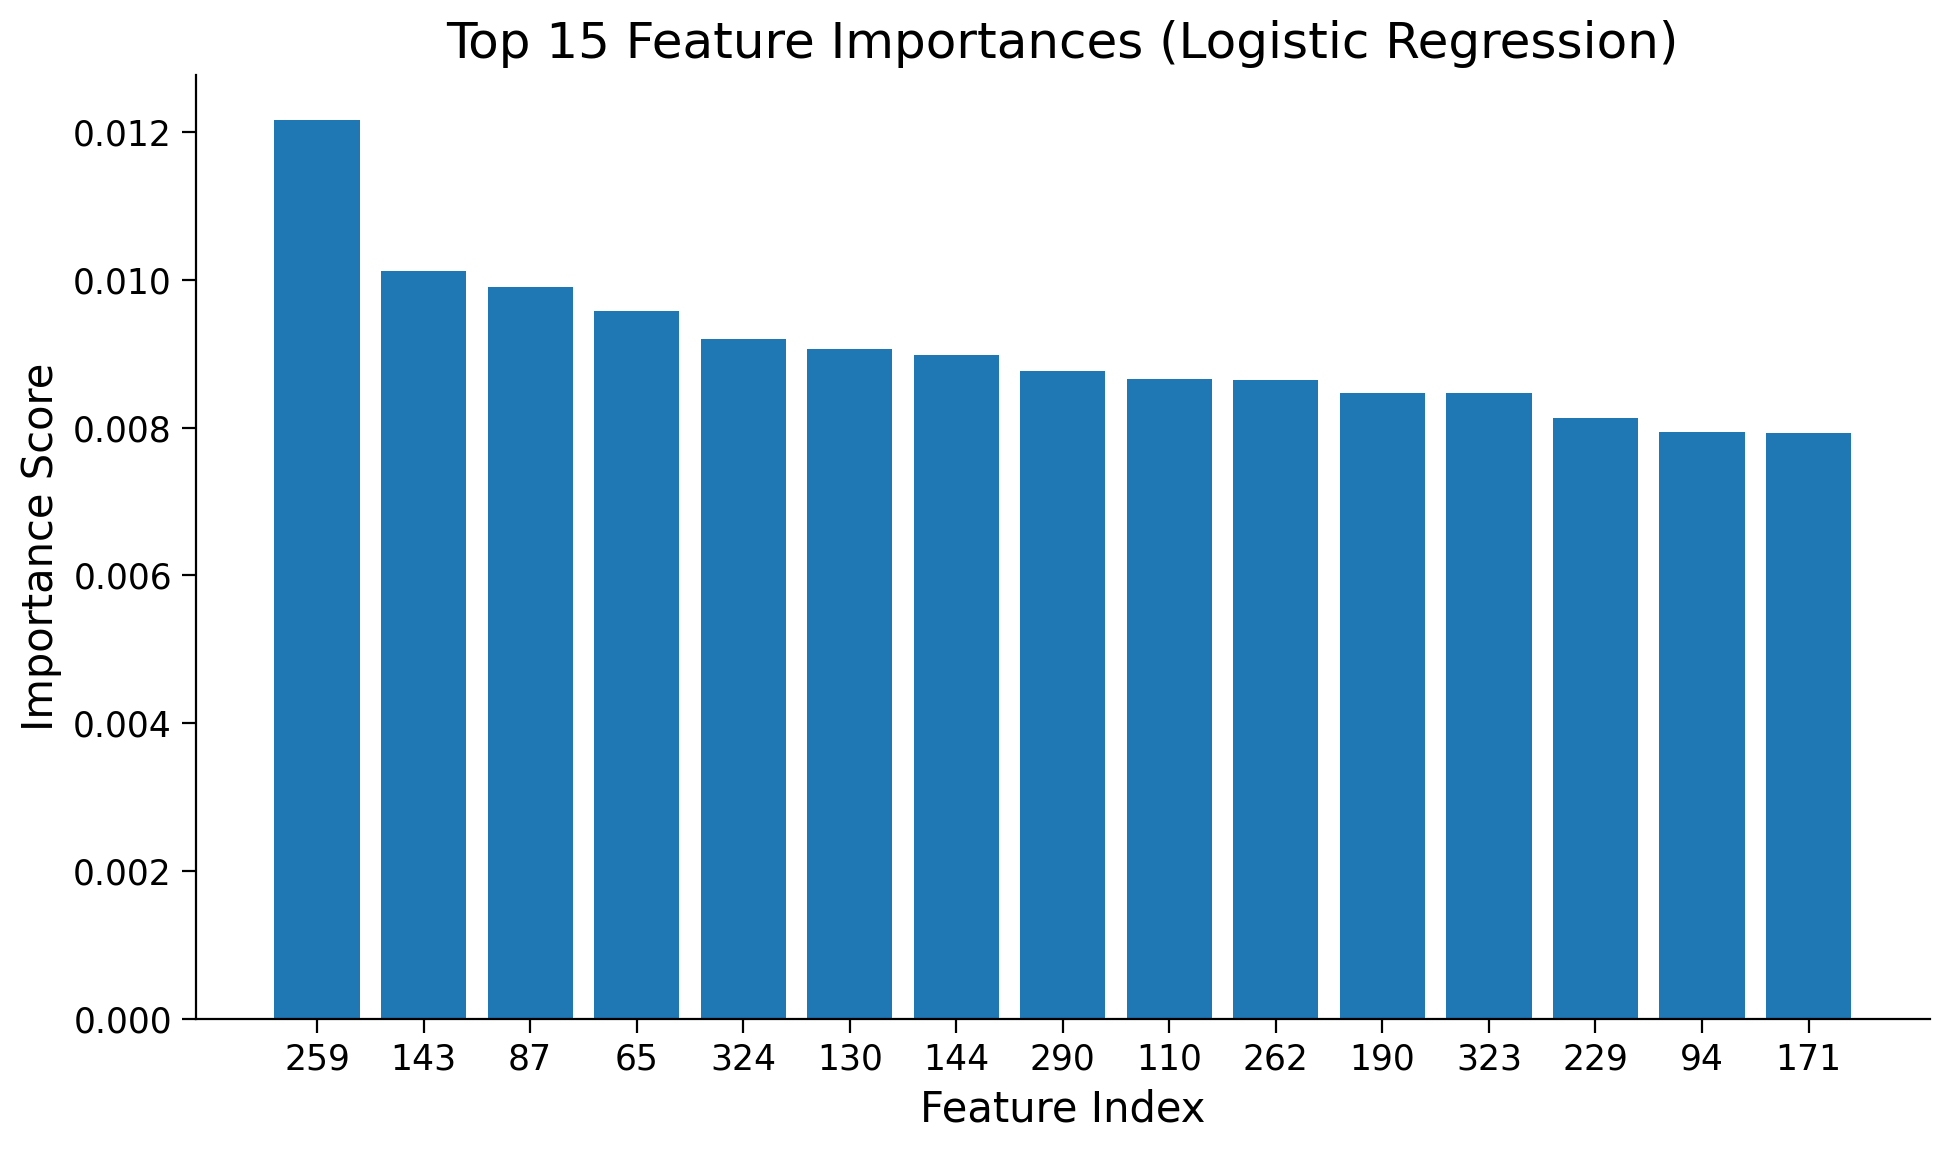

In [36]:
gs_fitted = gs.fit(X_language, y_language)
lr_gs = LogisticRegression(**(gs_fitted.best_params_))

lr_gs.fit(X_language, y_language)

coefficients = lr_gs.coef_[0]
importances = np.abs(coefficients)

indices = np.argsort(importances)[::-1]
top_indices = indices[:15]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances (Logistic Regression)")
plt.bar(range(15), importances[top_indices], align="center")
plt.xticks(range(15), top_indices)
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

### Timeseries and PCA (and DL start)

In [67]:
task = "LANGUAGE"
conditions = ["math", "story"]

math_story = []
for subject in subjects:

    # Get the average signal in each region for each condition
    evs = [load_evs(subject, task, cond, dir=os.path.join(HCP_DIR, "hcp_task")) for cond in conditions]
    avgs = [selective_average(timeseries_language[subject], ev, actually_average=False) for ev in evs]

    math_story.append(avgs)

for i in range(len(math_story)):
    for j in range(len(math_story[i])):
        math_story[i][j] = math_story[i][j][:,:281]

math_story_pca = np.array(math_story)

math_pca_a1 = math_story_pca[:,0,:,:]
story_pca_a1 = math_story_pca[:,1,:,:]

math_story_pca.shape

(339, 2, 360, 281)

In [68]:
math_data_a2e1 = math_pca_a1.reshape(339, -1)
story_data_a2e1 = story_pca_a1.reshape(339, -1)

math_story_data_a2 = np.concatenate((math_data_a2e1, story_data_a2e1), axis=0)
math_story_data_a2.shape

(678, 101160)

In [69]:
X_ts = math_story_data_a2
y_ts = np.array([1]*(math_story_data_a2.shape[0]//2) + [0]*(math_story_data_a2.shape[0]//2))

In [70]:
pca = PCA(n_components=300).fit(X_ts)
X_ts_t = pca.transform(X_ts)

In [73]:
param_grid_rfc = {
    'n_estimators': [10, 25, 50],
    'max_depth': [2, 3, 4]
}

gs = nested_cv(RandomForestClassifier(random_state=88), param_grid_rfc, X_ts_t, y_ts)

The mean score using nested cross-validation is: 0.963 ± 0.012


In [75]:
param_grid_abc = {
    'n_estimators': [10, 25, 50],
}

gs = nested_cv(AdaBoostClassifier(random_state=88), param_grid_abc, X_ts_t, y_ts)

The mean score using nested cross-validation is: 0.991 ± 0.000


In [76]:
param_grid_lr = {
    'C': [0.05, 0.1, 0.5, 1],
    'penalty': ['l1','l2'],
}

ss = StandardScaler().fit(X_ts_t)

X_ts_t_s = ss.transform(X_ts_t)

gs = nested_cv(LogisticRegression(random_state=88), param_grid_lr, X_ts_t_s, y_ts)

The mean score using nested cross-validation is: 0.971 ± 0.002


### DL

In [77]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from tqdm import tqdm

In [87]:
# Go convolute -> -> ->

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=(3,3)),
            nn.ReLU(),
            nn.Conv2d(4, 4, kernel_size=(3,3)),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(222784, 2)
        )

    def forward(self, x):
        x = self.net(x.float())
        return x

In [81]:
class MyDataset(Dataset):

    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                         torchvision.transforms.Resize((240,240))])


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.transform(self.images[idx])
        return image.to(float), label

In [82]:
math_story_data_a3 = np.concatenate((math_pca_a1, story_pca_a1), axis=0)
labels_a3 = np.array([1]*(math_story_data_a3.shape[0]//2) + [0]*(math_story_data_a3.shape[0]//2))

In [83]:
train_images, test_images, train_labels, test_labels = train_test_split(
                                                                        math_story_data_a3,
                                                                        labels_a3,
                                                                        test_size=0.2,
                                                                        random_state=88,
                                                                        shuffle=True
                                                                       )

In [84]:
batch_size = 8

train_dataset = MyDataset(images=train_images, labels=train_labels)
test_dataset = MyDataset(images=test_images, labels=test_labels)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

dataloaders = {
    'train': train_dataloader,
    'test': test_dataloader
}

In [85]:
def train_model(model, criterion, optimizer, batch_size, dataloaders, num_epochs=10):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for i, (inputs, labels) in enumerate(tqdm(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / (len(dataloaders[phase])*batch_size)
            epoch_acc = (running_corrects) / (len(dataloaders[phase])*batch_size)

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))

    return model

In [88]:
device = torch.device('cpu')
criterion = torch.nn.CrossEntropyLoss()
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model_trained = train_model(model, criterion, optimizer, batch_size, dataloaders, num_epochs=3)

Epoch 1/3
----------


100%|██████████| 68/68 [00:11<00:00,  5.67it/s]


train loss: 5.9262, acc: 0.9154


100%|██████████| 17/17 [00:00<00:00, 36.45it/s]


test loss: 1.0997, acc: 0.9853
Epoch 2/3
----------


100%|██████████| 68/68 [00:09<00:00,  7.20it/s]


train loss: 0.4993, acc: 0.9871


100%|██████████| 17/17 [00:00<00:00, 28.74it/s]


test loss: 0.7664, acc: 0.9926
Epoch 3/3
----------


100%|██████████| 68/68 [00:08<00:00,  8.31it/s]


train loss: 0.0000, acc: 0.9963


100%|██████████| 17/17 [00:00<00:00, 38.22it/s]

test loss: 0.7315, acc: 0.9926
